In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h1 style='text-align: center'}>Prediction of the Russian Housing Market</h1>

# 1. Introduction
The Russian housing market, shaped by its diverse regions and economic fluctuations, poses unique challenges for accurate property valuation and investment forecasting. In this project, I will leverage a comprehensive dataset provided by Sberbank, Russia's largest bank, to build sophisticated models that will predict and analyze real estate prices. By incorporating property-specific features and macroeconomic indicators, I will aim to provide a detailed understanding of the key factors that influence property values and market dynamics.


<b>`Main Goal:`</b> The primary objective of this project will be to predict the sale price `(price_doc)` of residential properties in Russia. I will use machine learning techniques to ensure that my model is robust and accurate. However, I will go beyond simple price prediction to explore additional models and targets that will offer a richer and more nuanced analysis of the housing market.

The project will focus on several key components to provide a comprehensive analysis of the Russian housing market:
1. `Price per Square Meter:` I will predict normalized property values to facilitate easier comparisons across regions, enhancing the understanding of relative value.
2. `Price Appreciation/Depreciation:` By estimating the annualized rate of value change, I will provide insights that inform long-term investment strategies and help investors anticipate future property performance.
3. `Time to Sale:` I will develop models to predict the duration a property will remain on the market, assisting in pricing and marketing strategies.
4. `Property Investment Classification:` I will categorize properties by their investment potential, helping investors identify lucrative opportunities quickly.
5. `Sale Likelihood:` I will classify properties based on their probability of selling within specified timeframes, offering real estate professionals a tool to prioritize their marketing efforts.
6. `Market Trend Classification:` I will assess whether local markets are **"Rising", "Stable" or "Falling"** providing strategic insights for homebuyers and investors

# 2. Reading the data
To begin, I’ll load the necessary datasets into my workspace. This step is essential for setting up the core data I’ll need throughout the project.
By reading the data into DataFrames, I’ll be ready to explore its structure and contents, which will help guide the data cleaning and preprocessing steps that follow.

In [7]:
train = pd.read_csv("train.csv/train.csv")
test = pd.read_csv("test.csv/test.csv")
macro = pd.read_csv("macro.csv/macro.csv")

Now, I’ll perform an initial inspection of both the `training` and `macro` datasets to understand their structure, dimensions, and variable types.

In [8]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [9]:
dimensions = {
    'Training dataset shape': train.shape,
    'Macro dataset shape': macro.shape
}
dimensions

{'Training dataset shape': (30471, 292), 'Macro dataset shape': (2484, 100)}

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [11]:
macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   timestamp                                   2484 non-null   object 
 1   oil_urals                                   2484 non-null   float64
 2   gdp_quart                                   2394 non-null   float64
 3   gdp_quart_growth                            2394 non-null   float64
 4   cpi                                         2453 non-null   float64
 5   ppi                                         2453 non-null   float64
 6   gdp_deflator                                2119 non-null   float64
 7   balance_trade                               2453 non-null   float64
 8   balance_trade_growth                        2394 non-null   float64
 9   usdrub                                      2481 non-null   float64
 10  eurrub     

The initial inspection shows that the training dataset is large, with 30,471 rows and 292 columns, while the macro dataset is smaller, with 2,484 rows and 100 columns. Both datasets are predominantly numerical, with some categorical columns that may require encoding.

# 3. Data formatting
 I’ll prepare and structure the datasets for seamless integration and analysis. First, I’ll ensure that date information in both datasets is standardized by converting the `timestamp` column to a datetime format. After this,<b> I’ll merge the training and macr datasets</b>  on the `timestamp` column, allowing me to enrich the training data with additional macroeconomic features. This data formatting step is crucial for aligning and consolidating the information, setting up a consistent foundation for the modeling phase.

In [21]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
macro['timestamp'] = pd.to_datetime(macro['timestamp'])

In [22]:
train['timestamp']

0       2011-08-20
1       2011-08-23
2       2011-08-27
3       2011-09-01
4       2011-09-05
           ...    
30466   2015-06-30
30467   2015-06-30
30468   2015-06-30
30469   2015-06-30
30470   2015-06-30
Name: timestamp, Length: 30471, dtype: datetime64[ns]

In [23]:
merged_df = pd.merge(train, macro, on="timestamp", how="left")

In [24]:
merged_df.shape

(30471, 391)

After merging, I checked the shape of the DataFrame to confirm success. The result is `(30471, 391)`, matching the original 30,471 rows and showing an increase in columns from 292 to 391. This confirms that the merge was successful, with the macro features correctly added by `timestamp`.

# 4. Missing values


In this step, I’ll analyze and handle missing values in the merged dataset to improve data quality for analysis and modeling. Missing values can impact the performance of machine learning models, so it's essential to assess the extent of missing data and make informed decisions about handling it. First, I’ll start by identifying which columns contain missing values and visualize the proportion of missing data in each of these columns.

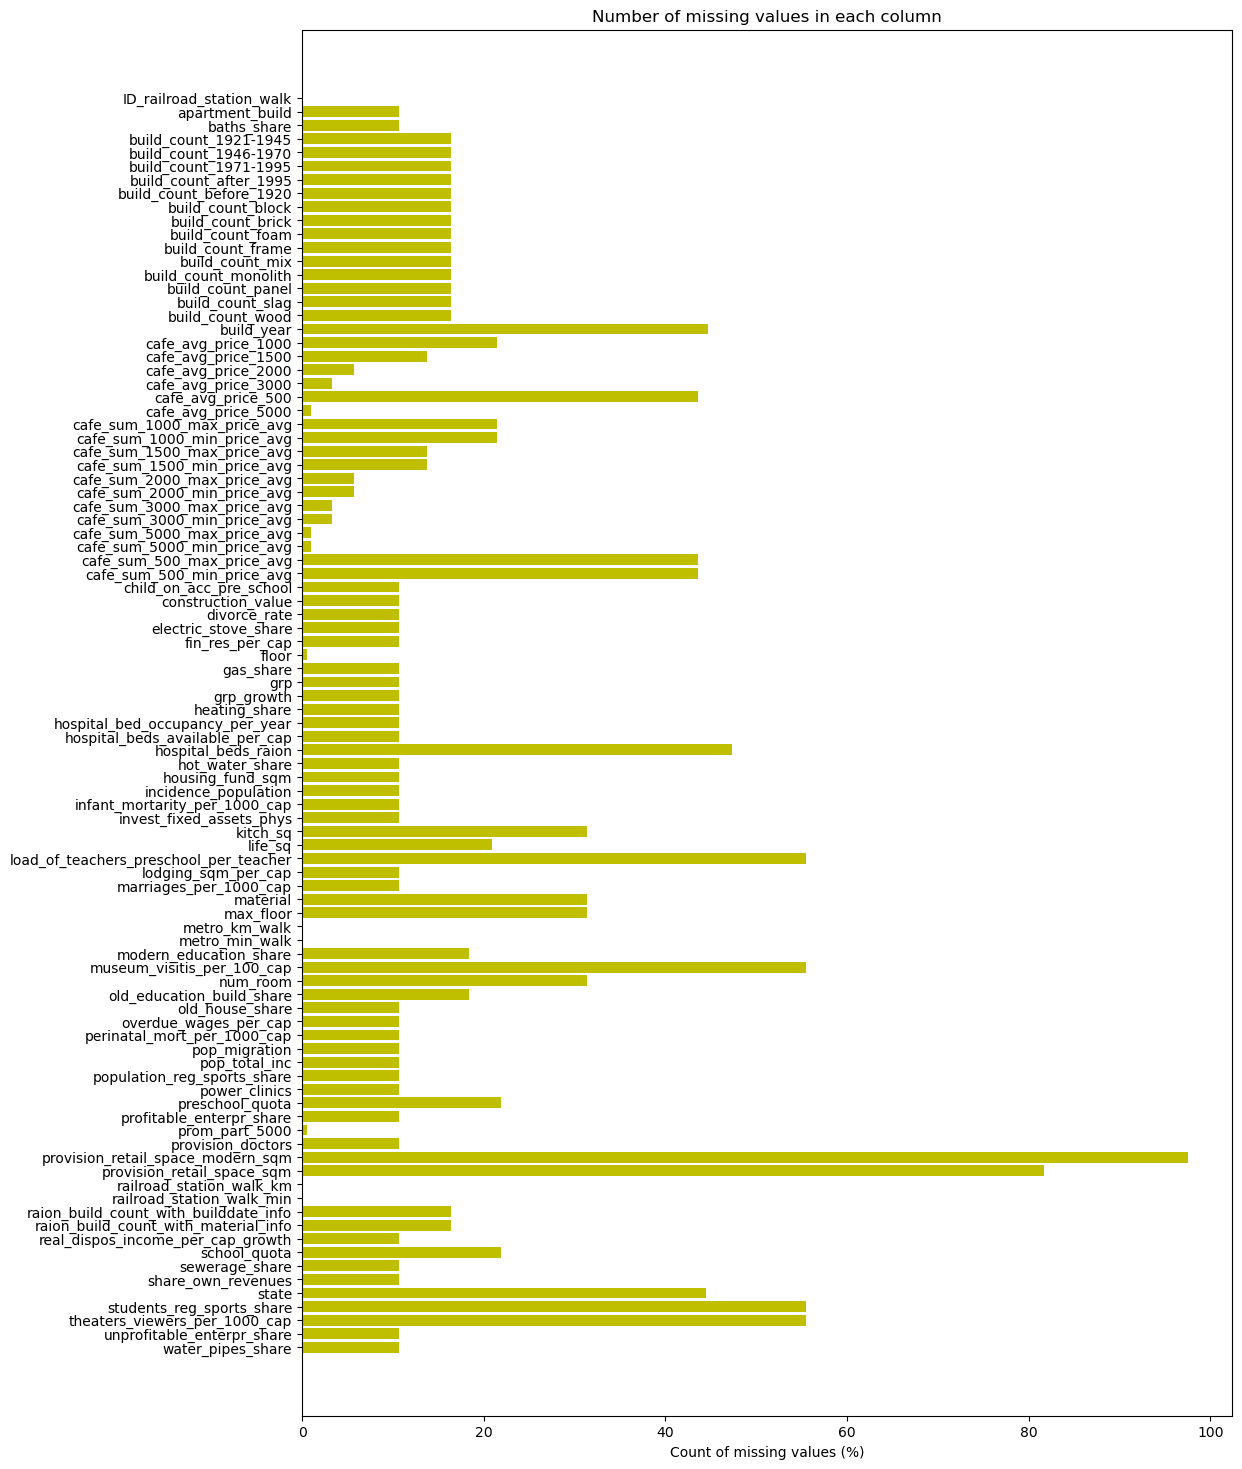

In [28]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='column_name', ascending=False)

ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values / merged_df.shape[0] * 100, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values (%)")
ax.set_title("Number of missing values in each column")
plt.show()

In [29]:
print(f"Number of columns with missing values: {len(missing_df)}")

Number of columns with missing values: 93


Next, I’ll set a threshold to decide which columns to keep based on the percentage of missing values. I’ve chosen a threshold of 50%, meaning that any column with more than 50% missing values will be removed. This helps to eliminate columns that are too incomplete to provide meaningful information, ensuring that the dataset remains relevant and manageable for further analysis.

In [30]:
threshold = merged_df.shape[0] * 0.5
threshold

15235.5

In [34]:
merged_df = merged_df.loc[:, merged_df.isnull().sum(axis=0) <= threshold]

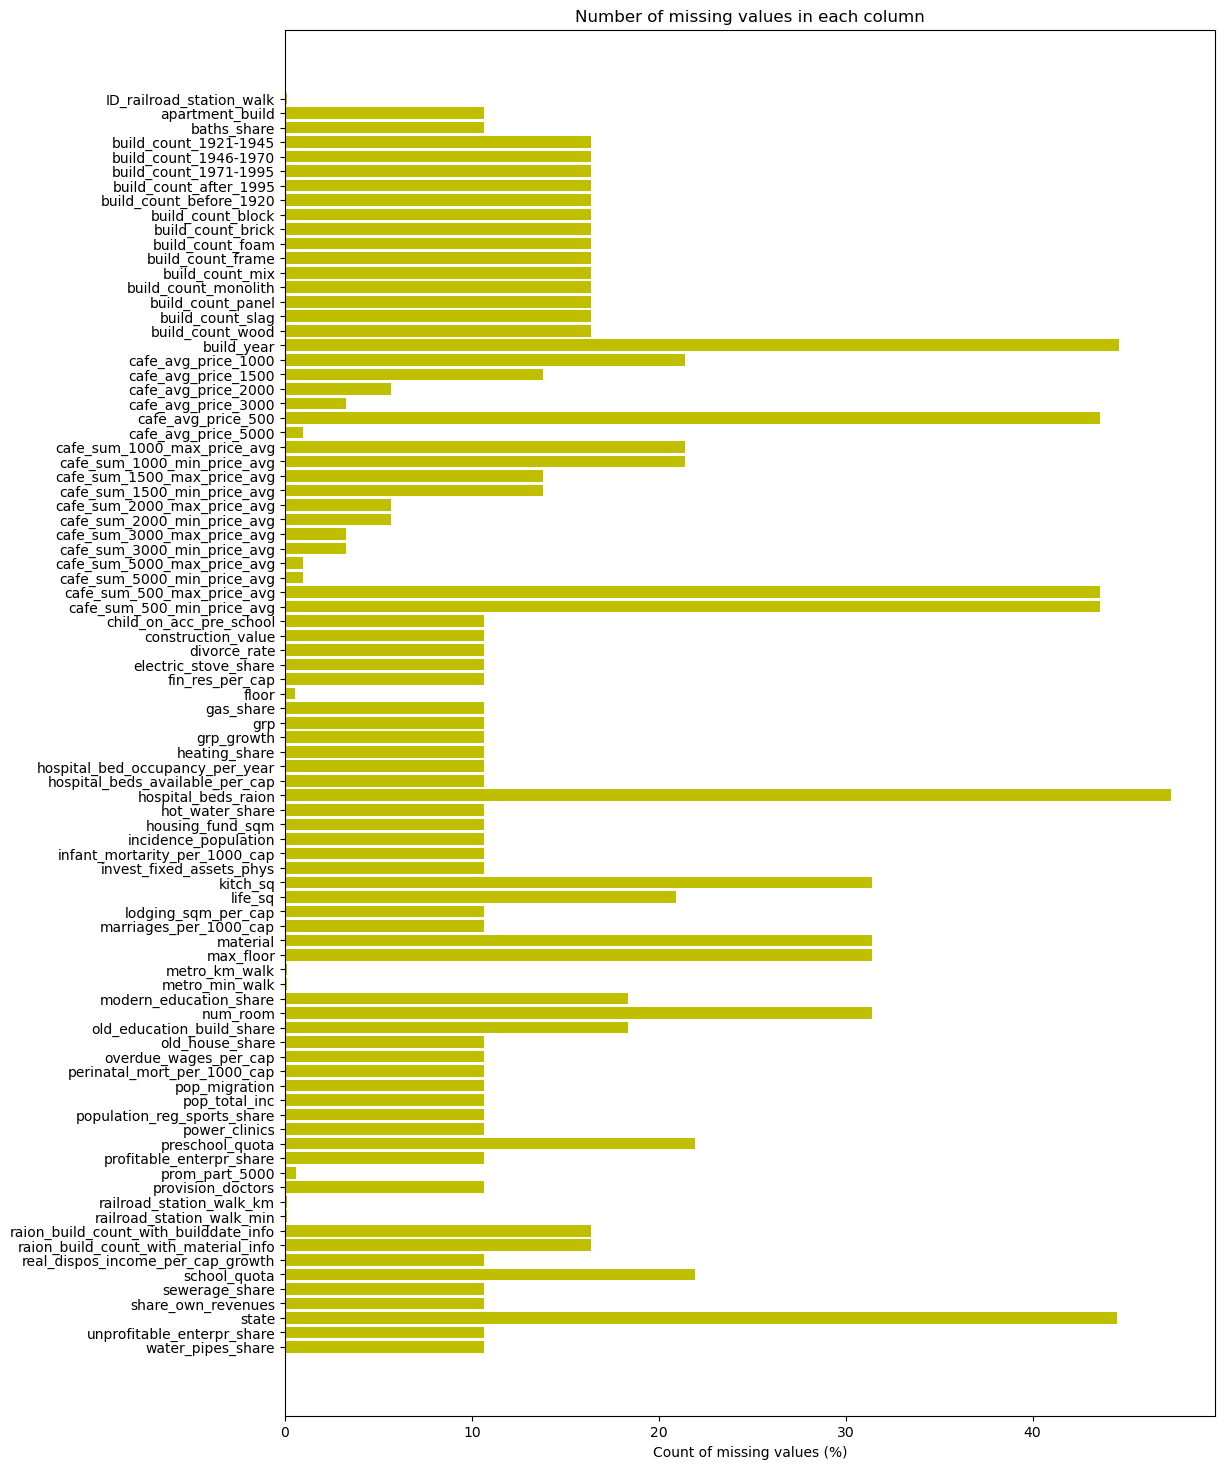

In [35]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='column_name', ascending=False)

ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values / merged_df.shape[0] * 100, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values (%)")
ax.set_title("Number of missing values in each column")
plt.show()

In [36]:
print(f"Number of columns with missing values: {len(missing_df)}")

Number of columns with missing values: 87


6 columns are dropped from the dataset.

Now, I’ll address the missing values in the dataset by filling them with appropriate values based on the type of data in each column.

In [43]:
columns_to_fill_with_zero = [
    'ID_railroad_station_walk',
    'apartment_build',
    'baths_share',
    'build_count_1921-1945',
    'build_count_1946-1970',
    'build_count_1971-1995',
    'build_count_after_1995',
    'build_count_before_1920',
    'build_count_block',
    'build_count_brick',
    'build_count_foam',
    'build_count_frame',
    'build_count_mix',
    'build_count_slag',
    'build_count_monolith',
    'build_count_panel',
    'build_count_wood',
    'cafe_avg_price_1000',
    'cafe_avg_price_1500',
    'cafe_avg_price_2000',
    'cafe_avg_price_3000',
    'cafe_avg_price_500',
    'cafe_avg_price_5000',
    'construction_value',
    'electric_stove_share',
    'gas_share',
    'heating_share',
    'sewerage_share', 
    'water_pipes_share', 
    'modern_education_share', 
    'school_quota',
    'preschool_quota',
    'hospital_bed_occupancy_per_year',
    'hospital_beds_available_per_cap',
    'hospital_beds_raion',
    'provision_doctors', 
    'railroad_station_walk_km',
    'railroad_station_walk_min', 
    'raion_build_count_with_builddate_info',
    'raion_build_count_with_material_info',
    'hot_water_share',
    'housing_fund_sqm',
    'cafe_sum_1000_max_price_avg',
    'cafe_sum_1000_min_price_avg',
    'cafe_sum_1500_max_price_avg',
    'cafe_sum_1500_min_price_avg',
    'cafe_sum_2000_max_price_avg',
    'cafe_sum_2000_min_price_avg',
    'cafe_sum_3000_max_price_avg',
    'cafe_sum_3000_min_price_avg',
    'cafe_sum_5000_max_price_avg',
    'cafe_sum_5000_min_price_avg',
    'cafe_sum_500_max_price_avg',
    'cafe_sum_500_min_price_avg',
    'profitable_enterpr_share', 
    'unprofitable_enterpr_share', 
    'share_own_revenues',
    'metro_km_walk',
    'metro_min_walk'
]

merged_df.loc[:, columns_to_fill_with_zero] = merged_df.loc[:, columns_to_fill_with_zero].fillna(0)

In [42]:
merged_df.child_on_acc_pre_school.unique()

array(['#!', '7,311', '3,013', '16,765', nan], dtype=object)

In [27]:
merged_df.child_on_acc_pre_school.unique()

array([   nan,  7.311,  3.013, 16.765])

In [28]:
merged_df.old_education_build_share.unique()

array([nan, '23,14', '25,47', '8,2517'], dtype=object)

In [26]:
merged_df['child_on_acc_pre_school'] = merged_df['child_on_acc_pre_school'].replace({',': '.'}, regex=True)

merged_df['child_on_acc_pre_school'] = pd.to_numeric(merged_df['child_on_acc_pre_school'], errors='coerce')

merged_df['old_education_build_share'] = pd.to_numeric(merged_df['old_education_build_share'].replace({',': '.'}, regex=True), errors='coerce')

In [30]:
columns_to_fill_with_median = [
    'fin_res_per_cap', 
    'grp_growth', 
    'invest_fixed_assets_phys',
    'overdue_wages_per_cap', 
    'real_dispos_income_per_cap_growth',
    'floor', 
    'max_floor', 
    'num_room', 
    'housing_fund_sqm',
    'kitch_sq', 
    'lodging_sqm_per_cap', 
    'old_education_build_share', 
    'old_house_share',
    'incidence_population', 
    'infant_mortarity_per_1000_cap',
    'perinatal_mort_per_1000_cap', 
    'marriages_per_1000_cap',
    'pop_total_inc', 
    'population_reg_sports_share',
    'divorce_rate',
    'grp',
    'power_clinics',
    'life_sq',
    'pop_migration',
    'prom_part_5000',
    'build_year',
    'child_on_acc_pre_school'
]

merged_df[columns_to_fill_with_median] = merged_df[columns_to_fill_with_median].fillna(merged_df[columns_to_fill_with_median].median())

27

In [32]:
columns_to_fill_with_mode = [
    'material',
    'state'
]

for column in columns_to_fill_with_mode:
    mode_value = merged_df[column].mode()[0]  
    merged_df[column] = merged_df[column].fillna(mode_value) 

5. Correlations if 2 features are highly correlated, remove one of them, if there are too many left, do a PCA with 2, 3, 4, 5 components, and see which features have high impact in the pca components, and remove these with high values.

In [57]:
obj = merged_df.select_dtypes(include = ['object', 'datetime64[ns]'])

In [62]:
numeric_columns_df = merged_df.select_dtypes(include=['float64', 'int64'])

In [64]:
corr_matrix = numeric_columns_df.corr().abs()

In [65]:
corr_matrix

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm
id,1.000000,0.021447,0.011919,0.021096,0.041155,0.244193,0.003688,0.039330,0.000415,0.009777,...,0.762572,0.800264,0.679912,0.574314,0.901647,0.410311,0.940352,0.828300,0.413598,0.217225
full_sq,0.021447,1.000000,0.151406,0.089085,0.057650,0.017168,0.002632,0.333761,0.009695,0.039139,...,0.023697,0.021646,0.029871,0.029666,0.022352,0.020688,0.023268,0.012166,0.024058,0.021801
life_sq,0.011919,0.151406,1.000000,0.032337,0.033413,0.014049,0.002229,0.170746,0.003408,0.048718,...,0.000281,0.009083,0.012123,0.011736,0.010570,0.004981,0.008694,0.010660,0.007522,0.004971
floor,0.021096,0.089085,0.032337,1.000000,0.371492,0.019545,0.000363,0.002176,0.007286,0.088592,...,0.033539,0.005701,0.009160,0.005929,0.012274,0.029345,0.022411,0.012807,0.011149,0.017556
max_floor,0.041155,0.057650,0.033413,0.371492,1.000000,0.057608,0.000203,0.016924,0.020689,0.057017,...,0.027545,0.033569,0.025232,0.020310,0.037988,0.010843,0.038524,0.037430,0.013110,0.001980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seats_theather_rfmin_per_100000_cap,0.410311,0.020688,0.004981,0.029345,0.010843,0.044859,0.008081,0.012791,0.005459,0.068029,...,0.875973,0.146015,0.662974,0.683213,0.234711,1.000000,0.461790,0.040981,0.748824,0.952420
bandwidth_sports,0.940352,0.023268,0.008694,0.022411,0.038524,0.231938,0.004213,0.031955,0.000226,0.006874,...,0.822460,0.834571,0.757305,0.650597,0.949268,0.461790,1.000000,0.862399,0.483892,0.260673
population_reg_sports_share,0.828300,0.012166,0.010660,0.012807,0.037430,0.239475,0.000693,0.046353,0.002415,0.035345,...,0.442357,0.853927,0.426415,0.287859,0.930247,0.040981,0.862399,1.000000,0.072824,0.255023
apartment_build,0.413598,0.024058,0.007522,0.011149,0.013110,0.048282,0.002649,0.023399,0.002633,0.076875,...,0.666491,0.038768,0.918002,0.957666,0.242753,0.748824,0.483892,0.072824,1.000000,0.678461


6. EDA

7. Feature engineering - ratios, etc.

one-hot encodings, (optional) PCA

Feature binning - [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] --> numerical, ===> ["1-3", "3-6", "6-9"]

8. Train test split

9. Model selection - Linear regression, Random Forrest, Ada Boost, XGBoost

10. Model evaluation - MSE, RMSE

11. Hyperparameter tuning

12. Here you can see the p-values of the features in the linear regression, the shap values in the other models, feature importances as well. The features that have high p-values, and low feature importances can be removed - but you have to see how it impacts the performance of the model.

(optional) unsupervised learning

13. Conclusion